# Visualising the pulsar data

This notebook visualises the frequency, $v$, vs phase data, $\phi$, recorded from the 42 ft telescope at JBO. 

The dispersion in the data is used to calculate the dispersion mesaure $DM$.

Finally, an optimization program is run to obtain the de-dispersed data.

In [1]:
# Imports and preamble
from __future__ import (print_function, absolute_import, division)
import os
import scipy.optimize as opt
import numpy as np
import scipy

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime

from  matplotlib import pyplot as plt
import matplotlib

from math import pi

%matplotlib inline
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1. Data Functions

### 1.1 Reading Data

In [6]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP")

def read_data(file_name):
    """
    Reads the data from ascii files.
    
    @param file_name :: name of the file
    
    @returns :: three arrays with the channel counts,
                phase_counts and data.
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(data_dir, file_name)
    
    chan_count, phase_count, data = \
    np.loadtxt(data_file, usecols=(1,2,3), unpack=True, skiprows=1)
    
    return chan_count, phase_count, data

### 1.2 Organising Data

In [34]:
def get_numbers(chan_count, phase_count):
    """
    Gets the number of channels and the
    number of phase bins of the data.
    
    @param chan_count :: channel counts as read from 
                         the data file
    @param phase_count :: same for phase
    
    @returns :: number of channels and number of phases
    """
    
    nchan=int(chan_count[-1])+1
    nphase=int(phase_count[-1])+1
    
    return nchan, nphase


def reshape_data(nchan, nphase, data):
    """
    Reshapes the data into 2d structure so it is usable.
    
    @param nchan :: number of frequency channels
    @param nphase :: number of phase bins
    @param data :: intensity data
    
    @returns :: 2d data structure, array of channels and
                array of phases
    """
    
    raw = data.reshape(nchan,nphase)
    iphase = phase_count.reshape(nchan,nphase)[0] 
    ichan = chan_count.reshape(nchan,nphase)[:,0]
    
    return raw, ichan, iphase


def freq_integral(raw):
    """
    Takes the data and integrates it over all
    frequency channels.
    
    @param raw :: 2d data structure
    
    @returns :: data integrated along frequency
    """
    
    integrated = np.sum(raw, axis=0)
    
    return integrated


def convert_axis(ichan, iphase):
    """
    Convert the channels of frequency and the phase
    array into physical things.
    
    @param ichan :: array of channels of data
    @param iphase :: array of phases of data
    
    @returns :: array of frequencies and array of times
    """
    
    freq = 605.125 + ichan * (10/nchan)
    time = iphase*(0.71452/nphase)
    
    return freq, time

### 1.3 Plotting the data

In [47]:
def density_plot(data, freq, time):
    """
    
    """
    
    dens_plot = plt.figure(figsize=(12,12))
    plt.subplot(211)
    plt.imshow(data, aspect='auto', origin='lower', 
               extent=(time[0],time[-1],freq[0],freq[-1]))
    plt.title("Density Plot")
    plt.xlabel("Time (s)",)
    plt.ylabel("Frequency (MHz)")
    plt.subplots_adjust(bottom=0.1, top=0.9)


def intensity_plot(integrated, time):
    """
    
    """
    
    intens_plot = plt.figure(figsize=(12,12))
    plt.subplot(211)
    plt.plot(time, integrated)
    plt.xlabel("Phase (iphase)")
    plt.ylabel("Intensity (Arbitrary)")
    plt.title("Integrated profile")
    plt.subplots_adjust(bottom=0.1, top=0.9)

### 2. Dispersion Measure Functions

### 2.1 Shifting

In [92]:
def shift_rows(data_in, shifts):
    """
    Shifts the rows of the data by amount in variable "shifts".
    
    @param data_in :: data to be shifted
    @param shifts :: amount to be shifted by
    
    @returns :: sifted data
    """
    
    shifted=np.zeros_like(data_in)
    for chan in range(nchan):
        shifted[chan] += np.roll(data_in[chan],int(shifts[chan]))
    return shifted

def shifting(x, data_in, freq, nphase):
    """
    Shifts the data by an array times the variable m.
    Tries to dedisperse the data this way.
    
    @param m :: shifting parameter
    @param nchan :: number of channels in the data
    @param ichan :: array to be shifted with
    
    @returns :: negative of the maximum of the integrated frequency
    """
    
    bindelay = (x[0] * 4148.8 * nphase)/(0.71452 * pow(freq, 2))
    dedispersed = shift_rows(data_in, bindelay)
    integrated = np.sum(dedispersed,axis=0)
    
    return -np.amax(integrated)


def shifting_results(x, constants):
    """
    Does the same thing as function shifting.
    
    @returns :: the bindelay, dedispersed and integrated
                numpy arrays
    """
    
    bindelay = (x[0] * 4148.8 * constants[2])/(0.71452 * pow(constants[1], 2))
    
    dedispersed = shift_rows(constants[0], bindelay)
    integrated = np.sum(dedispersed, axis=0)
    
    return bindelay, dedispersed, integrated

### 2.2 Dispersion Measure Thorugh Optimization

In [90]:
def find_dispersion(initial_guess, shifting, constants):
    """
    
    """
    res = opt.minimize(shifting, [initial_guess], constants, method="Nelder-Mead")
    bindelay, dedispersed, integrated = shifting_results(res.x, constants)
    
    print("Dispersion Measure: %2.5f" %(abs(res.x[0])))
    print("Corresponding maximum value of intensity %2.5f" %(-res.fun))
    print(res)
    
    return bindelay, dedispersed, integrated

## 3. Kowalski, Analysis.

In [11]:
chan_count, phase_count, data = read_data('B03529_Wed1')
nchan, nphase = get_numbers(chan_count, phase_count)
raw, ichan, iphase = reshape_data(nchan, nphase, data)
integrated = freq_integral(raw)
freq, time = convert_axis(ichan, iphase)

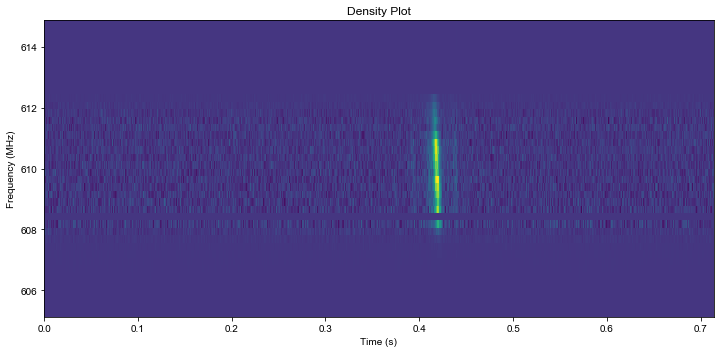

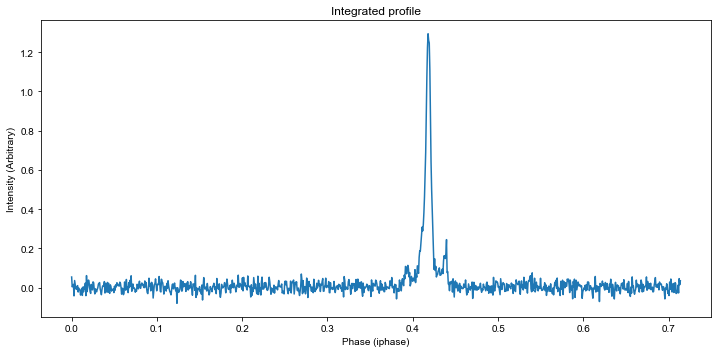

In [48]:
density_plot(raw, freq, time)
intensity_plot(integrated, time)

In [88]:
bindelay, dedispersed, integrated = find_dispersion(-20, shifting, (raw, freq, nphase))

Dispersion Measure: 20.01562
Corresponding maximum value of intensity 1.44047
 final_simplex: (array([[-20.015625  ],
       [-20.01568604]]), array([-1.44047378, -1.44047378]))
           fun: -1.440473776389
       message: 'Optimization terminated successfully.'
          nfev: 39
           nit: 16
        status: 0
       success: True
             x: array([-20.015625])


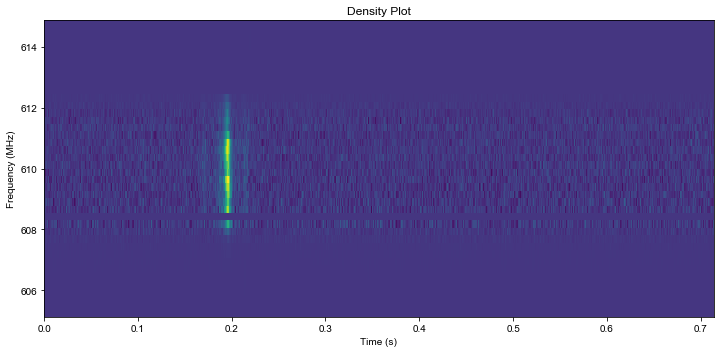

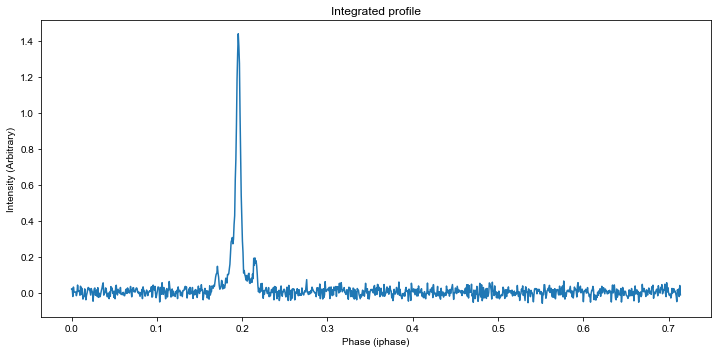

In [89]:
density_plot(dedispersed, freq, time)
intensity_plot(integrated, time)